This notebook reproduces the Lorentz results from [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116). The data generation is specified in the  [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) of [Champion et. al](https://www.pnas.org/doi/full/10.1073/pnas.1906995116), and is restated here. 


The data was syntheticaly generated using the governing lorentz
equations


$$
\begin{aligned}
\dot{z}_1 =& \sigma (z_2 - z_1) \\



\dot{z}_2 =& z_1 (\rho - z_3) - z_2 \\



\dot{z}_3 =& z_1 z_2 - \beta z_3 \\

\end{aligned}
$$

with the standard paramater values $\sigma = 10$, $\beta = \frac{8}{3}$ and $\rho = 28$

This data is then trnsformed using the first 6 legendre polynomials.


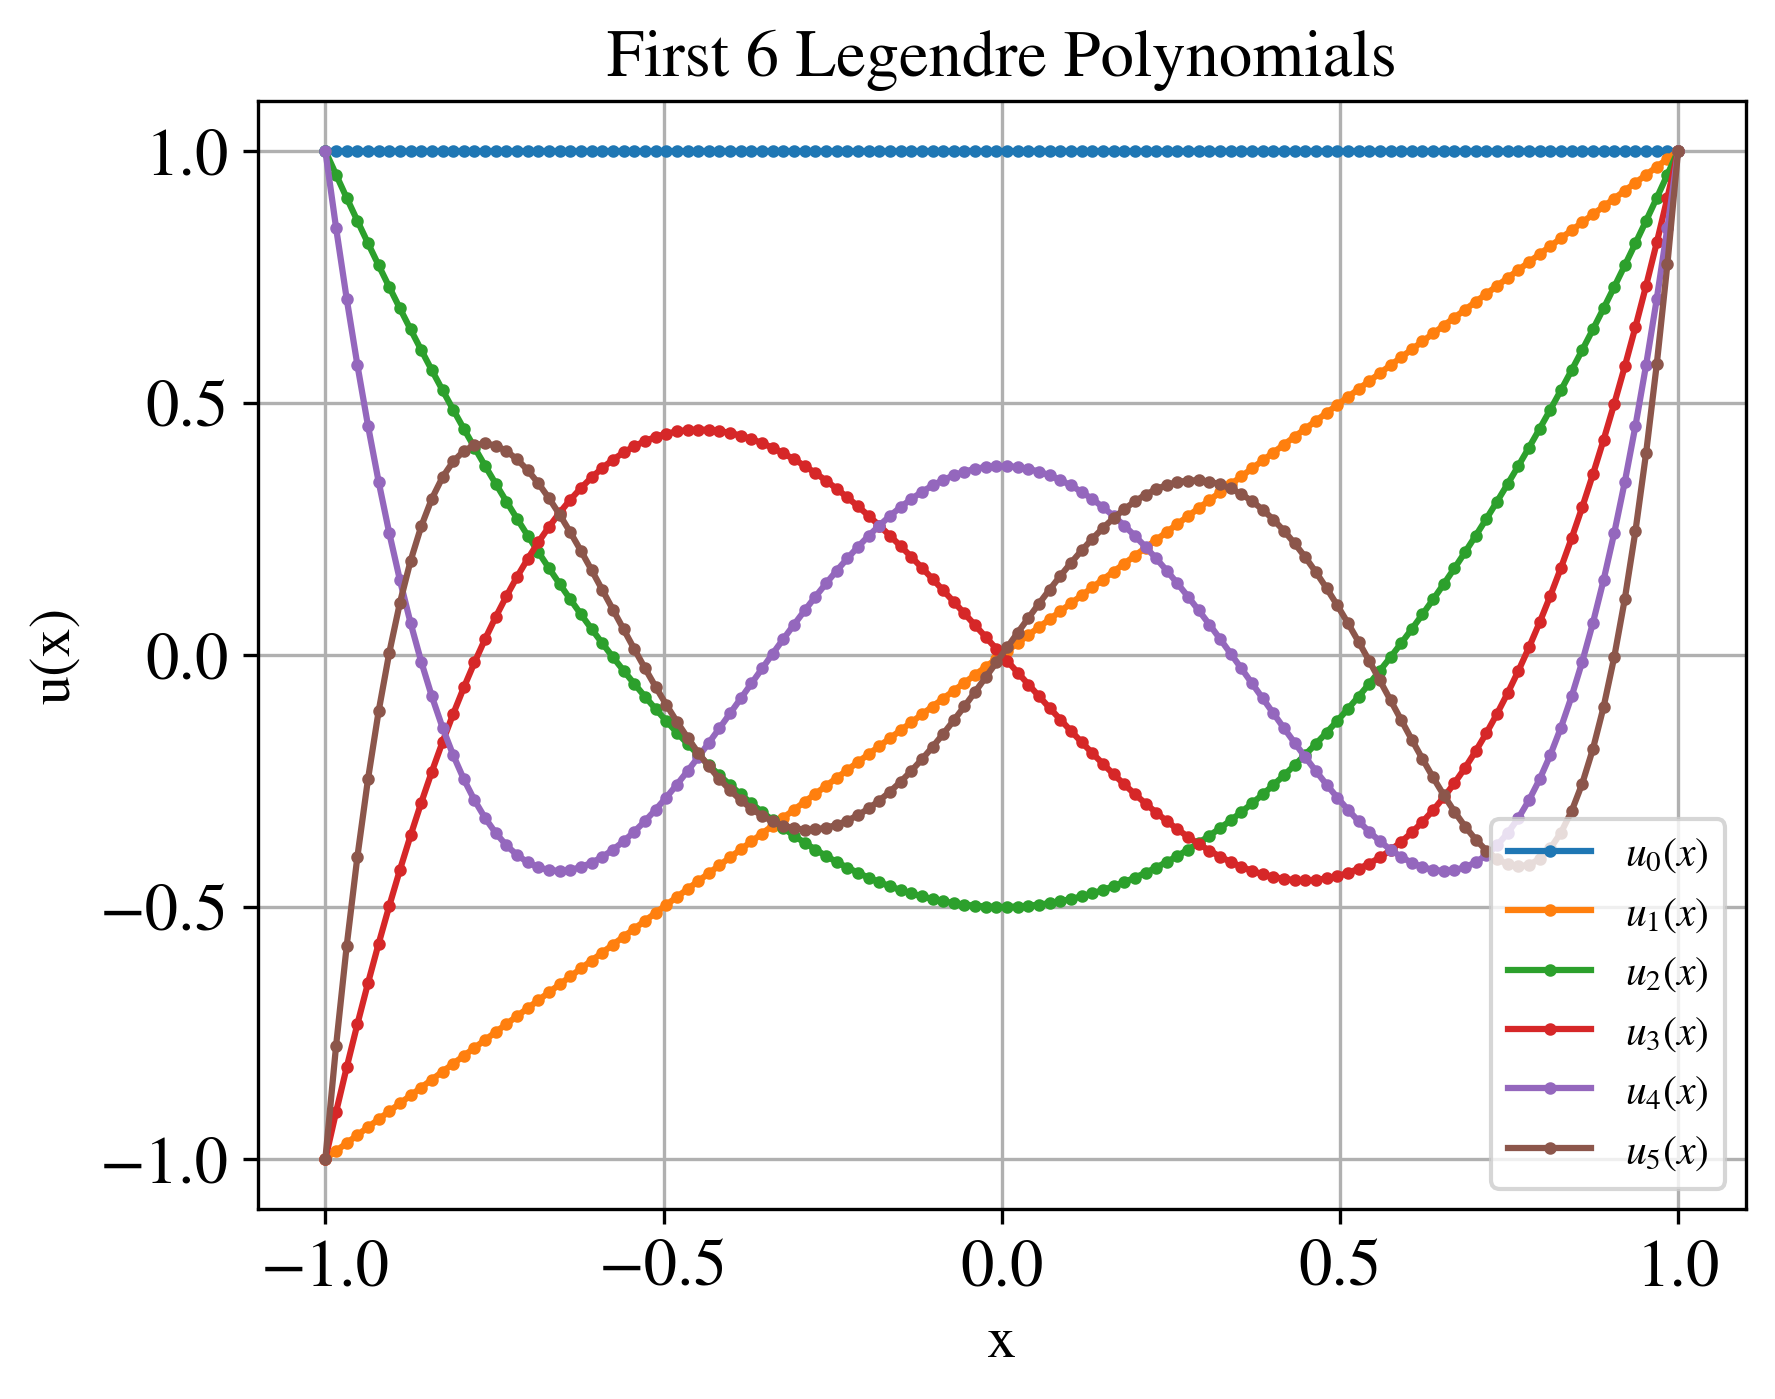

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import legendre

plt.style.use("../plot_utils/plot_settings.mplstyle")

x = np.linspace(-1, 1, 128)

# Plot the first 6 Legendre polynomials
for n in range(6):
    u_n = legendre(n)
    y = u_n(x)
    # Plot the polynomial
    #make the 
    plt.plot(x, y, label=f'$u_{n}(x)$', marker='o', markersize=2)


plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('First 6 Legendre Polynomials')
plt.legend()
plt.grid(True)



Each datapoint $\boldsymbol{z} = [z_1, z_2, z_3]$ is mapped to a $\boldsymbol{x}$ by

$$
\boldsymbol{x}(t) = \boldsymbol{u_1} z_1(t) +  \boldsymbol{u_2}z_2(t) +  \boldsymbol{u_3}z_3(t) +  \boldsymbol{u_4}z_1(t)^3 +  \boldsymbol{u_5}z_2(t)^3 +  \boldsymbol{u_6} z_3(t)^3 
$$

Our $\boldsymbol{u}_n \in \mathbb{R}^{128}$ vectors correspond precisely to the ones depicted above; these are constructed by sampling the $n$-th Legendre polynomial at 128 equally spaced points within the interval $[-1, 1]$.

From the [appendix](https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1906995116&file=pnas.1906995116.sapp.pdf) 
"To generate our data set, we simulate the system with 2048 initial conditions for the training set, 20 for the validation set, and 100 for the test set. For each initial condition we integrate the system forward in time from t = 0 to t = 5 with a spacing of ∆t = 0.02 to obtain 250 samples. Initial conditions 93 are chosen randomly from a uniform distribution over $z_1$ ∈ [−36, 36], $z_2$ ∈ [−48, 48], $z_3$ ∈ [−16, 66]. This results in a training 94 set with 512,000 total samples"

The functions for generating such data is taken from [Kathleens github](https://github.com/kpchamp/SindyAutoencoders) and simply wrapped in some simple functions to create pytorch dataloaders.

In [2]:
import sys
sys.path.append('../')
from lorentzTorchData import get_lorenz_dataloader # type: ignore -goofy linitng issue

# generate training, validation, testing data
noise_strength = 1e-6
training_data = get_lorenz_dataloader(2, noise_strength=noise_strength)
validation_data = get_lorenz_dataloader(1, train=False, noise_strength=noise_strength)
testing_data = get_lorenz_dataloader(1, train=False, noise_strength=noise_strength)



In [3]:
from jax import random
from sindy_utils import library_size
from trainer import Trainer

# Set random key and hyperparameters
key = random.PRNGKey(0)
input_dim = 128
latent_dim = 3
poly_order = 3
widths = [64, 32]

# Get example input from training_data loader
x, dx = next(iter(training_data))
batch_size, num_features = x.shape

# Loss function parameters
loss_params = {
    'latent_dim': latent_dim,
    'poly_order': poly_order,
    'include_sine': False,
    'weights': (1, 1, 40, 1)
}

# Optimizer and logger hyperparameters
optimizer_hyperparams = {}
logger_params = {}

# Initialize trainer
trainer = Trainer(
    input_dim=input_dim,
    latent_dim=latent_dim,
    poly_order=poly_order,
    widths=widths,
    exmp_input=x,
    optimizer_hparams=optimizer_hyperparams,
    loss_params=loss_params,  # Pass the loss parameters here
    seed=42,
    logger_params=logger_params,
    check_val_every_n_epoch=100,
    update_mask_every_n_epoch=100
)

In [4]:
trainer.train_model(training_data, validation_data, num_epochs=300)

Epochs:  33%|███▎      | 98/300 [00:30<00:16, 12.57it/s]WARNING:absl:SaveArgs.aggregate is deprecated, please use custom TypeHandler (https://orbax.readthedocs.io/en/latest/custom_handlers.html#typehandler) or contact Orbax team to migrate before May 1st, 2024. If your Pytree has empty ([], {}, None) values then use PyTreeCheckpointHandler(..., write_tree_metadata=True, ...) or use StandardCheckpointHandler to avoid TypeHandler Registry error. Please note that PyTreeCheckpointHandler.write_tree_metadata default value is already set to True.


Saving metrics to: checkpoints/version_6\metrics\eval_epoch_100.json
Saving metrics to: checkpoints/version_6\metrics\best_eval.json


Epochs:  67%|██████▋   | 200/300 [01:12<06:04,  3.64s/it]

Saving metrics to: checkpoints/version_6\metrics\eval_epoch_200.json
Saving metrics to: checkpoints/version_6\metrics\best_eval.json


Epochs: 100%|██████████| 300/300 [01:44<00:00,  2.88it/s]

Saving metrics to: checkpoints/version_6\metrics\eval_epoch_300.json
Saving metrics to: checkpoints/version_6\metrics\best_eval.json


{'val/dynamics_dx': 237.26712036132812,
 'val/dynamics_dz': 26.296133041381836,
 'val/loss': 274.5429992675781,
 'val/reconstruction': 10.979736328125,
 'train/dynamics_dx': 1932.5257568359375,
 'train/dynamics_dz': 182.242431640625,
 'train/loss': 2137.792724609375,
 'train/reconstruction': 23.024566650390625,
 'epoch_time': 0.06596493721008301}

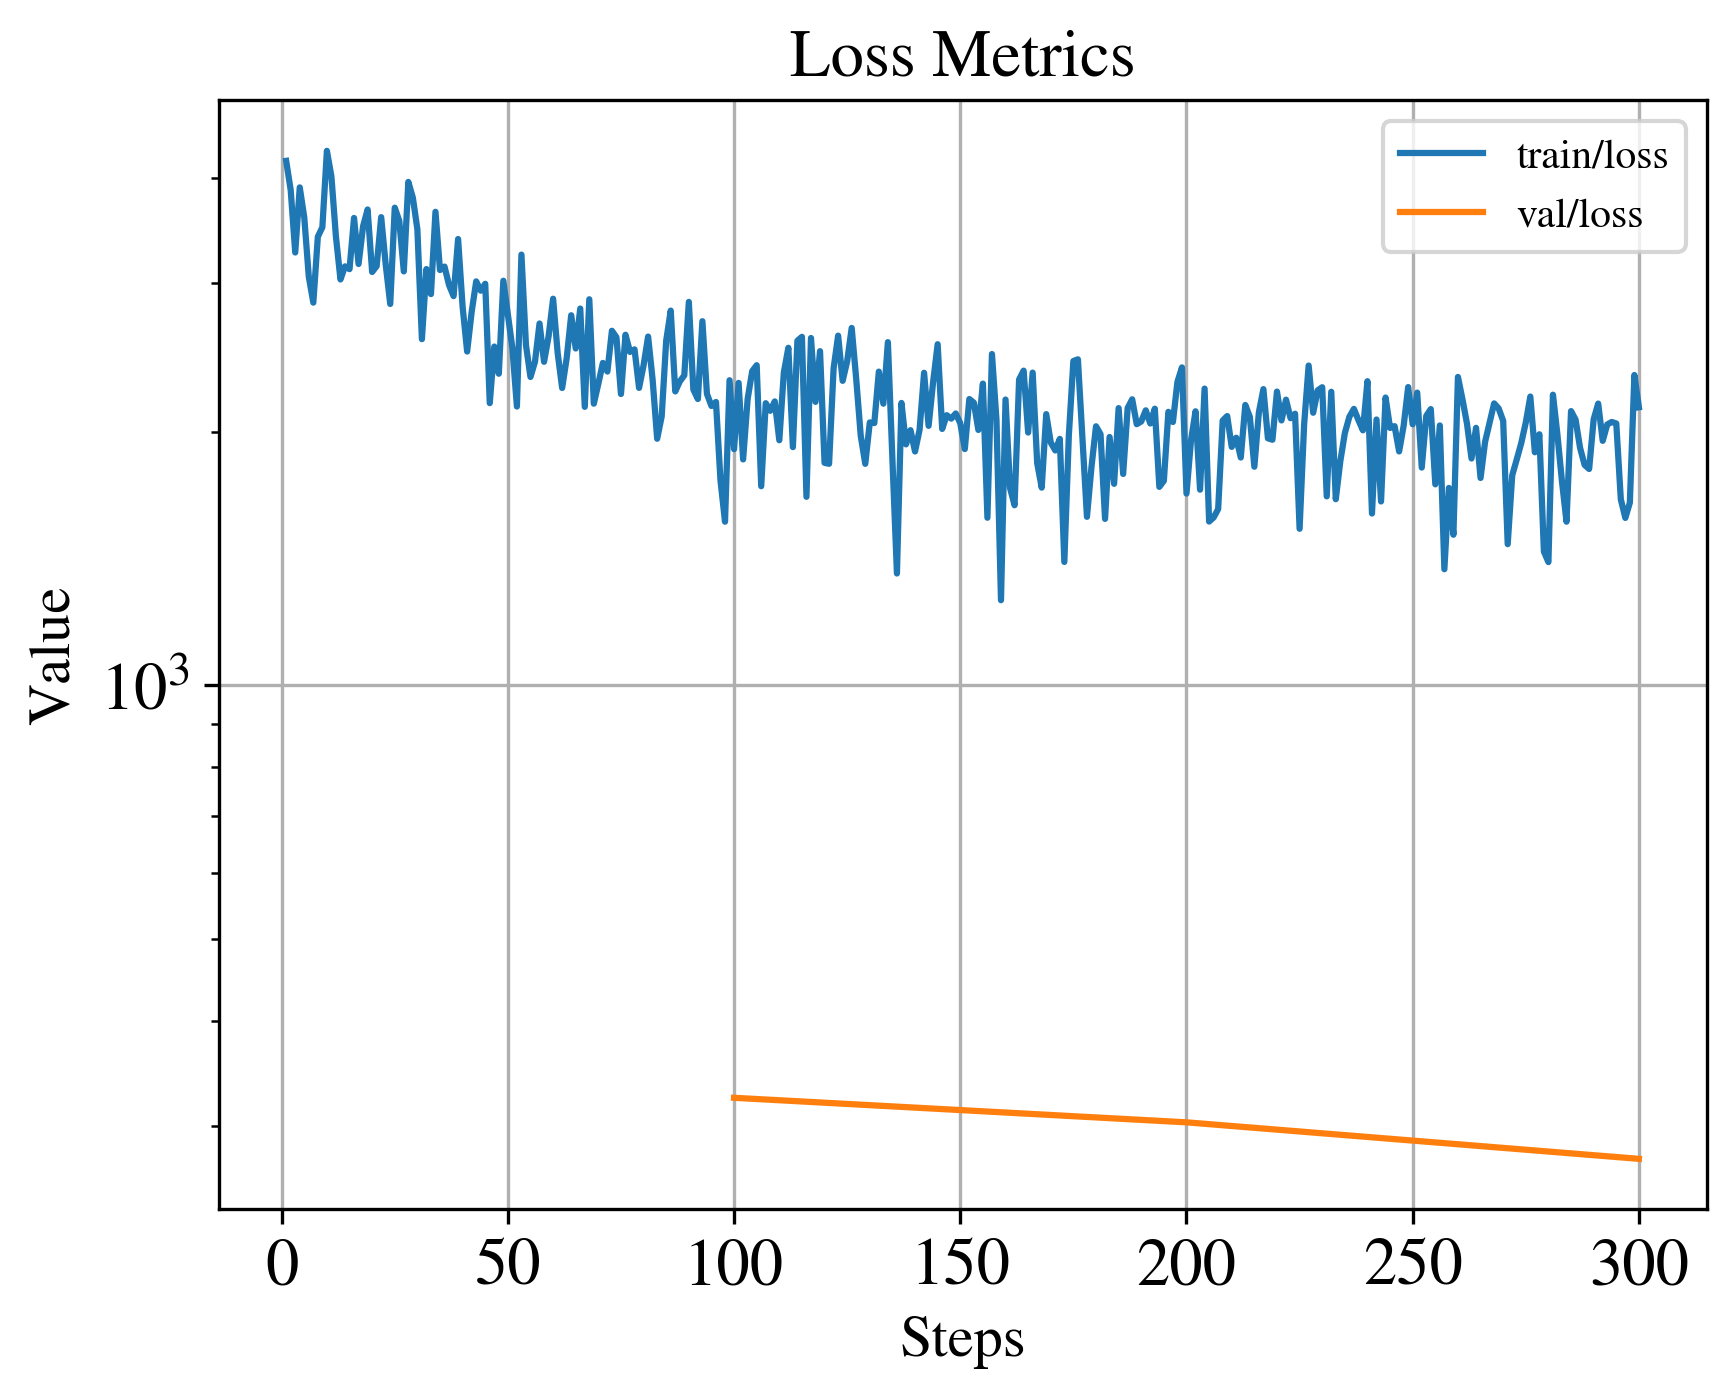

In [5]:
sys.path.append("../plot_utils")
from metrics import RunMetrics # type: ignore -goofy linitng issue
from plot_metrics import plot_metrics # type: ignore -goofy linitng issue

log_dir = trainer.log_dir

metrics = RunMetrics(log_dir)

# Plot a single run
plot_metrics(metrics, metric_names=["train/loss", "val/loss"], title="Loss Metrics")


## Get the sparse representation of the model ($\Xi$ )

In [6]:
mask = trainer.state.mask
xi = trainer.state.params['sindy_coefficients']
xi = xi * mask

print(xi)

[[0.9733817  1.0239218  0.9885182 ]
 [1.1237897  1.0785908  1.0764629 ]
 [0.7571933  0.8042304  0.83043134]
 [1.2730137  1.2520236  1.2189487 ]
 [1.111503   1.0680723  1.078556  ]
 [0.77350473 0.82303613 0.8420318 ]
 [1.2296169  1.2081076  1.2045975 ]
 [0.8088419  0.8646436  0.8867411 ]
 [1.1767302  1.1534598  1.1537203 ]
 [1.1209158  1.0724733  1.0863962 ]
 [1.1284665  1.1211176  1.1161569 ]
 [0.7672643  0.78717184 0.80641174]
 [1.2307696  1.2361051  1.2163042 ]
 [0.80194867 0.8211709  0.86572665]
 [1.1751882  1.1825681  1.1410037 ]
 [1.1130588  1.0856216  1.0774293 ]
 [0.81249565 0.84203947 0.87556547]
 [1.172408   1.1870978  1.1391187 ]
 [1.1328874  1.1095712  1.1078172 ]
 [1.1121546  1.0755194  1.0836537 ]]


In [7]:
from sindy_utils import get_expression

expression = get_expression(xi, poly_order=poly_order, include_sine=False)
#print(expression)